# Material Balances IX

This lecture solves more Material Balance Example Problems dealing with increasingly complex or non-intuitive reactor designs and constraints.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

(example-problem-01)=
## Example Problem 01

The reversible, gas-phase, homogeneous reaction shown below is carried out in a well-mixed batch reactor operating at a constant temperature $(T = 298K)$ and a constant pressure $(P = 1.0 \ \mathrm{atm})$. 

$$A \rightleftharpoons 4B$$

The reaction is first order in $A$ and fourth order in $B$ (strangely, it has elementary kinetics!); additional data are given below: 

\begin{align*}
    k_f &= 0.5 \ \textrm{min}^{-1}\\
    k_r &= 20 \ \textrm{L}^{3} \ \textrm{mol}^{-3} \textrm{min}^{-1}\\
    T   &= 298 \ \textrm{K}\\
    P   &= 1.0 \ \textrm{atm}\\
    V_0 &= 1.0 \ \textrm{L}\\
    K_C &= 0.025 \ \textrm{mol}^3 \ \textrm{L}^{-3}
\end{align*}

The reactor is initially charged with pure compound $A$.  How long will it take to achieve 80\% conversion of species $A$?

**Answer**: $t = 3.26 \ \mathrm{min}$

### Solution to Example Problem 01

Since this problem asks how long it will take to achieve a specific fractional conversion of A, it would make sense to start by writing a material balance on $A$ for this well-mixed batch reactor:

$$\frac{dN_A}{dt} = R_AV$$

We define $R_A$ in terms of the reaction rate $r_i$ and stoichiometric coefficients, $\nu_{i,j}$ to find:

$$R_A = -r$$

We are given reaction orders, so we can write a rate expression.

$$r = k_fC_A - k_rC_B^4$$

Here we see our first complication: the rate of reaction depends on the concentration of species $B$.  Our next complication arises when we define concentration.  Since we are in a batch reactor and working with $N_A$ and $N_B$ as state dependent variables, we define concentrations for $A$ and $B$ in terms of those state variables as:

\begin{align*}
    C_A &= N_A/V \\
    C_B &= N_B/V
\end{align*}

We see that the volume appears here. These concentrations represent the concentration in the reactor at any point in time, $t$. So, relative to the starting point, $N_A$ and $N_B$ are both changing. The less obvious thing is that the volume of the reactor is also changing.  Here's why: the reactor temperature and pressure are fixed at $T = 298K$ and $P = 1 \ \mathrm{atm}$, respectively.  Because the pressure is low, we can use the ideal gas law to define the volume of the system:

$$V = \frac{N_TRT}{P}$$

In other words, for a fixed temperature and pressure, the volume of the reactor scales directly with the total number of moles in the reactor. For this reaction, we can see clearly that every time the reaction occurs, it consumes 1 mole of $A$ and it produces $4$ moles of $B$. This means the reaction causes an increase in the number of moles in the system, so as it progresses, the volume of the reactor must increase if we are to maintain a constant temperature and pressure. The implication is that we also have to keep track of the total number of moles in our system:

$$N_T = N_A + N_B$$

The easiest way to handle this is to write a balance on each species and solve the set of coupled differential equations numerically:

\begin{align*}
    \frac{dN_A}{dt} = R_AV \\
    \frac{dN_B}{dt} = R_BV
\end{align*}

Now we just make sure that everything on the right hand side of those two balances is defined in terms of constants or the three variables tracked by our ODE solver -- our independent variabe, $t$, and our two state variables $N_A$ and $N_B$.

\begin{align}
    R_A = -r \\
    R_B = 4r
\end{align}

Where rate is given as:

$$r = k_fC_A - k_rC_B^4$$

This means we need to define concentrations in terms of NA and NB:

\begin{align}
    C_A = N_A/V \\
    C_B = N_B/V
\end{align}

And we know that Volume can be defined in terms of the total moles in the system; hence we define:

$$N_T = N_A + N_B$$

And use this result with the ideal gas law to calculate system volume.

$$V = \frac{N_TRT}{P}$$

Now $R_AV$ and $R_BV$ are fully defined in terms of $t$, $N_A$, and $N_B$, and we can solve this with `solve_ivp()`. Ultimately, after interpolation to find the time where $X_A = 0.8$, we find:

$$t = 3.26 \ \mathrm{min}$$

The time required to achieve 80% conversion is 3.26 minutes


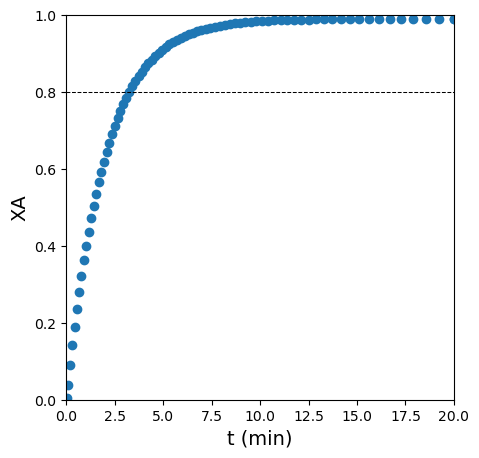

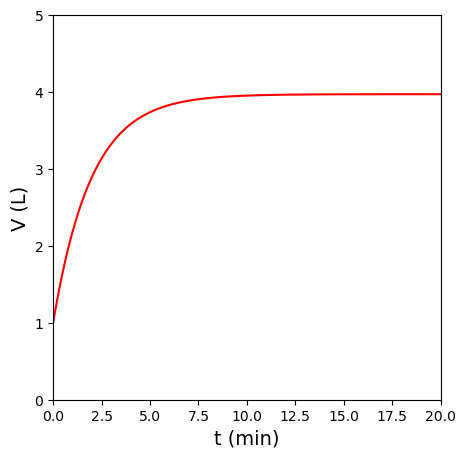

In [18]:
#########################################################################################
# Building the ODE system into a function that is compatible with solve_ivp()           #
# it will be of the form f(t, [NA, NB]), and it will return [dNAdt, dNBdt]              #
#########################################################################################

def P01(t, var):
    NA = var[0]
    NB = var[1]

    T = 298   #K
    P = 1.0   #atm
    R = 0.0821  #mol/L/K/atm
    kf = 0.5 #1/min
    kr = 20   #L^3/mol^3/min

    NT = NA + NB

    V  = NT*R*T/P

    CA = NA/V
    CB = NB/V

    r  = kf*CA - kr*CB**4
    RA = -r
    RB = 4*r
    D1 = RA*V
    D2 = RB*V
    return [D1, D2]

####################################################################################
# Define constants as global variables                                             #
####################################################################################

T     = 298   #K
P     = 1.0   #atm
R     = 0.0821  #mol/L/K/atm
V0    = 1.0   #L
yA0   = 1.0
yB0   = 0.0
NT0   = P*V0/R/T
NA0   = yA0*NT0
NB0   = yB0*NT0

####################################################################################
# Define additional necessary inputs for solve_ivp(), solve problem                #
####################################################################################

var0  = [NA0, NB0]
tspan = (0, 20)
ans   = solve_ivp(P01, tspan, var0, atol = 1e-10, rtol = 1e-10)

####################################################################################
# Extract relevant quantities from solution structure, workup to calculate XA, V   #
####################################################################################

t1    = ans.t
NA1   = ans.y[0,:]
NB1   = ans.y[1,:]
XA1   = (NA0 - NA1)/NA0
NT1   = NA1 + NB1
V1    = NT1*R*T/P

###################################################################################
# Create interpolating polynomial approximation for t(XA), find t(XA = 0.8)       #
###################################################################################

itp1 = interp1d(XA1, t1)
print(f'The time required to achieve 80% conversion is {itp1(0.8):0.2f} minutes')

####################################################################################
# Graph XA vs. time                                                                #
####################################################################################

plt.figure(figsize = (5,5))
plt.scatter(t1, XA1)
plt.hlines(0.8, 0, t1[-1], color = 'black', ls = 'dashed', lw = 0.75)
plt.xlim(0, 20)
plt.xlabel('t (min)', fontsize = 14)
plt.ylim(0, 1)
plt.ylabel('XA', fontsize = 14)
plt.show()

###################################################################################
# Graph V as a function of time; illustrate increase in volume                    #
###################################################################################

plt.figure(figsize = (5,5))
plt.plot(t1, V1, color = 'red')
plt.xlim(0, 20)
plt.xlabel('t (min)', fontsize = 14)
plt.ylim(0, 5)
plt.ylabel('V (L)', fontsize = 14)
plt.show()

## Example Problem 02

The reversible, gas-phase, homogeneous reaction shown below is carried out in a well-mixed batch reactor operating at a constant temperature $(T = 298K)$ and a constant Volume $(V = 1.0\mathrm{L})$. 

$$A \rightleftharpoons 4B$$

The reaction is first order in $A$ and fourth order in $B$; additional data are given below: 

\begin{align*}
    k_f &= 0.5 \ \textrm{min}^{-1}\\
    k_r &= 20 \ \textrm{L}^{3} \ \textrm{mol}^{-3} \textrm{min}^{-1}\\
    T   &= 298 \ \textrm{K}\\
    P_0 &= 1.0 \ \textrm{atm}\\
    V   &= 1.0 \ \textrm{L}\\
    K_C &= 0.025 \ \textrm{mol}^3 \ \textrm{L}^{-3}
\end{align*}

The reactor is initially charged with pure compound $A$.  How long will it take to achieve 80\% conversion of species $A$? 

```{note}
The only difference between this problem and [Example Problem 01](#example-problem-01) is that the reactor is now operating at constant volume instead of constant pressure.
```

### Solution to Example Problem 02

This problem is almost identical to the one above except for the fact that we fix the volume constant and no longer have to solve for it with the ideal gas law.  Otherwise, we approach it pretty much the same way.  Since my rate law depends on both $C_A$ and $C_B$, I'll write a balance on both species.

\begin{align}
    \frac{dN_A}{dt} = R_AV \\
    \frac{dN_B}{dt} = R_BV
\end{align}

Now we just make sure that everything on the right hand side of those two balances is defined in terms of contants or the three variables tracked by our ODE solver $(t, N_A, N_B)$.

\begin{align}
    R_A = -r \\
    R_B = 4r
\end{align}

Where rate is given as:

$$r = k_fC_A - k_rC_B^4$$

This means we need to define concentrations in terms of NA and NB:

\begin{align}
    C_A = N_A/V \\
    C_B = N_B/V
\end{align}

And in this case, the volume is fixed at 1.0L.  At this point, we have written all the equations that we need, and we can solve this with an ODE solver. 

0.7630069354428065


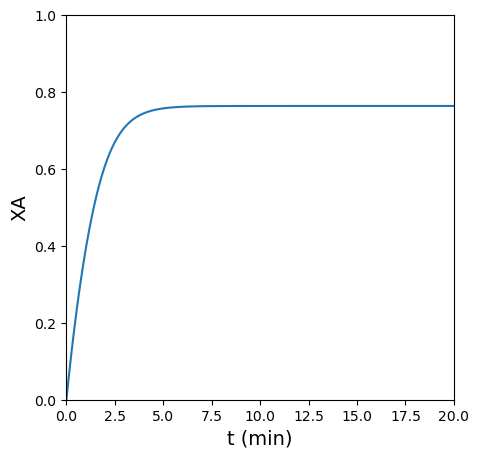

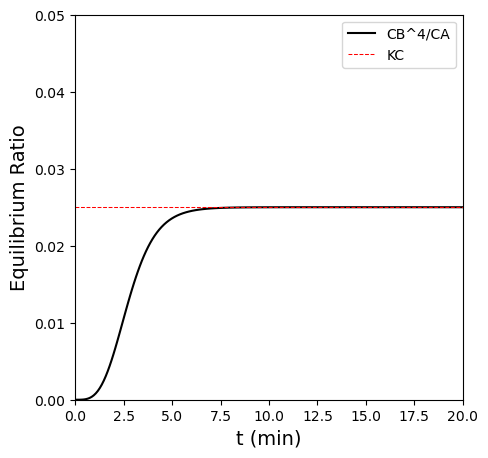

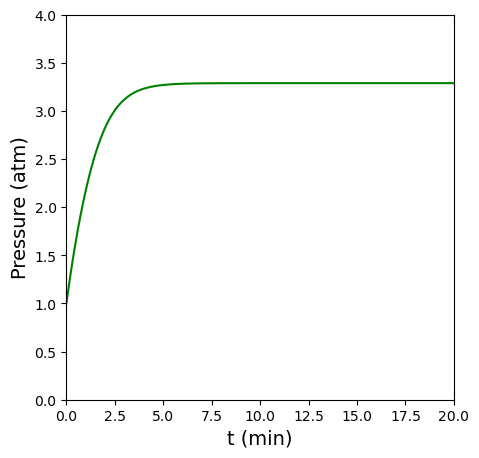

In [13]:
#########################################################################################
# Building the ODE system into a function that is compatible with solve_ivp()           #
# it will be of the form f(t, [NA, NB]), and it will return [dNAdt, dNBdt]              #
#########################################################################################

def P02(t,var):
    NA = var[0]
    NB = var[1]

    kf = 0.5  #1/min
    kr = 20   #L^3/mol^3/min

    V  = 1.0   #L

    CA = NA/V
    CB = NB/V

    r = kf*CA - kr*CB**4
    RA = -r
    RB = 4*r
    D1 = RA*V
    D2 = RB*V
    return [D1, D2]

####################################################################################
# Define constants as global variables                                             #
####################################################################################

T     = 298   #K
P0    = 1.0   #atm
R     = 0.0821  #mol/L/K/atm
V     = 1.0   #L
KC    = 0.025
NA0   = P0*V/R/T
NB0   = 0

####################################################################################
# Define solve_ivp() inputs and integrate the ODEs                                 #
####################################################################################

var0  = [NA0, NB0]
tspan = (0, 20)
sol   = solve_ivp(P02, tspan, var0, atol = 1e-10, rtol = 1e-10)

####################################################################################
# Extract relevant quantities and work up to get XA and P                          #
####################################################################################

t2    = sol.t
NA2   = sol.y[0,:]
NB2   = sol.y[1,:]
NT2   = NA2 + NB2
CA2   = NA2/V
CB2   = NB2/V
XA2   = (NA0 - NA2)/NA0
P2    = NT2*R*T/V

####################################################################################
# Create interpolating polynomial approximation for t(XA); find t(XA = 0.8)        #
####################################################################################

interp = interp1d(XA2, t2)
# interp(0.8) #Throws an error -- cannot reach XA = 0.8 in this system due to equilibrium constraint
print(XA2[-1])

####################################################################################
# Graph XA vs t                                                                    #
####################################################################################

plt.figure(figsize = (5, 5))
plt.plot(t2, XA2)
plt.xlim(0, 20)
plt.xlabel('t (min)', fontsize = 14)
plt.ylim(0, 1)
plt.ylabel('XA', fontsize = 14)
plt.show()

####################################################################################
# Graph reaction quotient vs. time; shows approach to equilibrium                  #
####################################################################################

plt.figure(figsize = (5, 5))
plt.plot(t2, CB2**4/CA2, color = 'black', label = 'CB^4/CA')
plt.hlines(KC, 0, 20, color = 'red', linestyle = 'dashed', linewidth = 0.75, label = 'KC')
plt.xlim(0, 20)
plt.xlabel('t (min)', fontsize = 14)
plt.ylim(0, 0.05)
plt.ylabel('Equilibrium Ratio', fontsize = 14)
plt.legend()
plt.show()

####################################################################################
# Graph pressure as a function of time                                             #
####################################################################################

plt.figure(figsize = (5, 5))
plt.plot(t2, P2, color = 'green')
plt.xlim(0, 20)
plt.ylim(0, 4)
plt.xlabel('t (min)', fontsize = 14)
plt.ylabel('Pressure (atm)', fontsize = 14)
plt.show()

```{important}
This reversible reaction reaches chemical equilibrium at about 76% conversion.  This is the maximum conversion that can be attained if we fix the reactor volume. The reason for this is actually that, by fixing the volume, we are forcing the pressure in the reactor to increase. As you can see in the stoichiometry for this reaction, there are more moles on the right hand side than the left hand side, so recalling Le Chatelier's principle, increasing pressure favors the left hand side and will decrease the equilibrium conversion we can attain.
```

## Example Problem 03

The reaction below is carried out in the liquid phase in a well-mixed batch reactor; you may assume these liquids behave as an ideal mixture. 

$$A \rightarrow B$$

The reaction is second order in A.  Additional data are given below. 

\begin{align}
    k &= 3.5 \times 10^{-3} \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{min}^{-1}\\
    {V_A}^\circ &= 50 \ \textrm{mL} \ \textrm{mol}^{-1}\\
    {V_B}^\circ &= 38.46 \ \textrm{mL} \ \textrm{mol}^{-1}\\
\end{align}

The reactor is initially charged with 10 moles of species $A$ $(N_{A0} = 10 \ \mathrm{moles})$. How long will it take to achieve 75% conversion of species $A$? 

**Answer**: $t = 37.5 \ \mathrm{minutes}$

### Solution to Example Problem 03

The problem asks about fractional conversion of $A$, so we will start by writing a balance on species $A$:

$$\frac{dN_A}{dt} = R_AV$$

If we want to solve this equation, we need to completely define everything on the right hand side in terms of $N_A$ and $t$. We can expand the production rate:

$$R_A = -r$$

And the reaction rate

$$r = kC_A^2$$

So far so good, it seems that the reaction rate only depends on the concentration of $A$. Now we try to define $C_A$ in terms of our state variable, $N_A$ and the volume of the liquid in the reactor, $V$:

$$C_A = N_A/V$$

Here, we have a problem. As the reaction happens, species $A$ is converted into species $B$, and the two species have different molar volumes. This means that each occupies a different amount of space per mole. In other words, they have different molar volumes (${V_j}^\circ)$ and densities. This means that the volume of liquid in the reactor changes as species $A$ is converted into species $B$, and we need an equation of state to relate the number of moles of species to the volume of the system. We are told in the problem statement that we can assume this behaves as an ideal mixtur. The equation of state for a perfect mixture is expressed as:

$$\sum_j C_j{V_j}^\circ = 1$$

The practical implication of a perfect mixture assumption is that the ***volumes occupied by each species are additive***.  Thus, when we have multiple species in a perfect mixture, we calculate the total volume of the system by adding the space occupied by each species:

$$V = \sum_j {V_j}$$

For a single species, $V_j$, we calculate the volume it occupies as:

$$V_j = N_j{V_j}^\circ$$

Making the substitution into our summation expression for total volume, $V$, we find:

$$V = \sum_j N_j{V_j}^\circ$$

In this particular example, we only have two species: $A$ and $B$; therefore:

$$V = N_A{V_A}^\circ + N_B{V_B}^\circ$$

This introduces a little more complexity in that we can now see that, in order to calculate $V$, we need to know $N_B$, which is a state dependent variable that changes as a function of time. Now we have two state dependent variables that define this system: $N_A$ and $N_B$. To solve the ODE system, we can either reduce the number of ODEs by writing both $N_A$ and $N_B$ as a function of the same state variable, like $X_A$. Alternatively, we can write a second material balance on species $B$ and solve the coupled ODEs simultaneously using `solve_ivp()`. We will choose the latter here, but we will also acknowledge that there is nothing incorrect about the former. In this case, the choice is a matter of convenience and preference. Our balance on $B$ is:

$$\frac{dN_B}{dt} = R_BV$$

With that, the right hand sides of our pair of ODEs are fully defined as functions of constants, $t$, $N_A$, and $N_B$, so this can be solved using `solve_ivp()`.

The time when conversion of A reaches 75% is 37.54 min


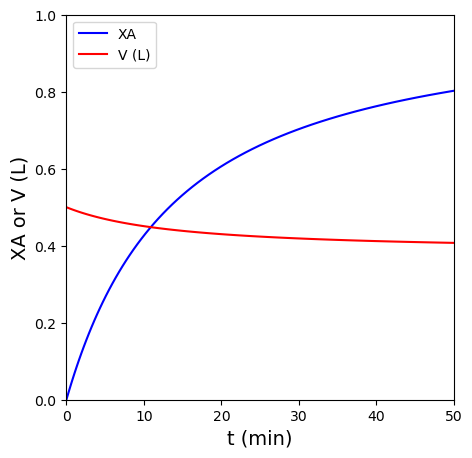

In [19]:
####################################################################################
# Define a function that encodes the ode problem                                   #
# it is of the form f(t, [NA, NB]) and it returns [dNAdt, dNBdt]                   #
#################################################################################### 

def P03(t, var):
    NA = var[0]
    NB = var[1]

    VA = 50e-3     #L/mol
    VB = 38.46e-3  #L/mol
    k  = 3.5e-3    #L/mol/min

    V  = NA*VA + NB*VB
    CA = NA/V

    r  = k*CA**2

    RA = -r
    RB = r
    D1 = RA*V
    D2 = RB*V
    return [D1, D2]

#######################################################################################
# Define constants as global variables                                                #
#######################################################################################

VA    = 50/1000  #L/mol
VB    = 38.46/1000 #L/mol
NA0   = 10  #mol
NB0   = 0   #mol

#######################################################################################
# Define additional parameters for solve_ivp(), integrate ODE system                  #
#######################################################################################

var0  = [NA0, NB0]
tspan = [0, 50]
ans   = solve_ivp(P03, tspan, var0, atol = 1e-10, rtol = 1e-10)

#######################################################################################
# Extract quantities of interest from the solution structure, calculate V and XA      #
#######################################################################################

t3    = ans.t
NA3   = ans.y[0,:]
NB3   = ans.y[1,:]
V3    = NA3*VA + NB3*VB
XA3   = (NA0 - NA3)/NA0

#######################################################################################
# Construct an interpolating polynomial approximation for t(XA), find t(0.75)         #
#######################################################################################

int1 = interp1d(XA3, t3, kind = 'cubic')
t_ans = int1(0.75)
print(f'The time when conversion of A reaches 75% is {t_ans:0.2f} min')

#######################################################################################
# Graph XA and V vs time                                                              #
#######################################################################################

plt.figure(figsize = (5,5))
plt.plot(t3, XA3, label = 'XA', color = 'blue')
plt.plot(t3, V3, label = 'V (L)', color = 'red')
plt.xlim(0, 50)
plt.xlabel('t (min)', fontsize = 14)
plt.ylim(0, 1)
plt.ylabel('XA or V (L)', fontsize = 14)
plt.legend(loc = 'upper left')
plt.show()